In [1]:
import sys
sys.path.append('./opt/conda/lib/python3.8/site-packages')
!{sys.executable} -m pip install gym

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors

from fnc_compress import *

import gym

from tqdm.notebook import tqdm

import copy

num_agents = 1
dataset_len = 1000

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

max_torque = 2.0
max_speed = 8
dt = 0.05
g = 10.0
m = 1.0
l = 1.0

# grid_dim = 25
# n_state = grid_dim**2
action_grid_dim = 25
# # n_action = action_grid_dim
actions1 = np.linspace(-max_torque,0,endpoint=False,num=int(action_grid_dim/2))
actions2 = np.linspace(0,max_torque,num=int(action_grid_dim/2))
actions = np.concatenate((actions1,actions2))
n_action = len(actions)
# speeds = np.linspace(-max_speed,max_speed,num=grid_dim)
# angles = np.linspace(-np.pi,np.pi,num=grid_dim)

ths = np.random.uniform(low=-np.pi,high=np.pi,size=(dataset_len,1))
thdots = np.random.uniform(low=-max_speed,high=max_speed,size=(dataset_len,1))
us = np.random.uniform(low=-max_torque,high=max_torque,size=(dataset_len,1))
# ths = np.random.choice(angles,size=dataset_len)[:,np.newaxis]
# thdots = np.random.choice(speeds,size=dataset_len)[:,np.newaxis]
# us = np.random.choice(actions,size=dataset_len)[:,np.newaxis]

subX = np.zeros((dataset_len,3,1))
subY = np.zeros((dataset_len,2,1))
in_states = np.zeros((dataset_len,2,1))
subX[:,:,0] = np.hstack((ths,thdots,us))

for k in range(dataset_len):
    th = subX[k,0,0]
    thdot = subX[k,1,0]
    u = subX[k,2,0]

    newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
    newthdot = np.clip(newthdot, -max_speed, max_speed)
    newth = th + newthdot * dt

    subY[k,0,0] = newth
    subY[k,1,0] = newthdot

nbrs = NearestNeighbors(n_neighbors=int(dataset_len/4), algorithm='ball_tree').fit(subX[:,:,0])
distances, indices = nbrs.kneighbors(subX[:,:,0])

N_kernel = 1
# sigmalist = [sigma_st/4]
sigmalist = [np.mean(distances.T[-1])]
# sigmalist = [1]
#sigmalist = [5./m]
etalist = [1]

nodes = np.arange(0,4)
iterateDx = {}
iterateDy = {}
iterateWxx = {}
iterateWyx = {}
dict_sizes = np.zeros(num_agents)

rcond_value = 1e-5

delta_tol = 1.0

for j in range(0,num_agents):

    if delta_tol<1.0:
        print('Compressing dictionary in node ',j)
        iterateDx[j],iterateDy[j],dict_inds = compressD(subX[:,:,j],subY[:,:,j],delta_tol,sigmalist,etalist)
        print('Shape of dictionary: ',iterateDx[j].shape)
        dict_sizes[j] = iterateDx[j].shape[0]
        iterateWxx[j],iterateWyx[j] = weightAverage(subY[:,:,j],subX[:,:,j],iterateDy[j],iterateDx[j],sigmalist,etalist,rcond_value)
    else:
        iterateDx[0] = subX[:,:,0]
        iterateDy[0] = subY[:,:,0]

    nx = len(iterateDx[j])
    KXX = rbf_kernel(iterateDx[j],gamma=1.0/(2.0*sigmalist[0]**2))
    W_new = np.linalg.inv(KXX+np.eye(nx))

val_states = iterateDy[0].T[0:2].T
rewards = np.zeros((nx,n_action))
alphas_new = np.zeros((nx,n_action,nx))

# # rewards= np.zeros((grid_dim**2,action_grid_dim))
# # alphas_new = np.zeros((grid_dim**2,n_action,nx))
for k, state in tqdm(enumerate(val_states)):
    dists = cdist(iterateDx[j],np.hstack((np.tile(state,[n_action,1]),actions[:,np.newaxis])),metric='sqeuclidean')
    alphas_new[k] = (W_new@np.exp(-dists/(2*sigmalist[0]**2))).T + 0.0000000001
    alphas_new[k] = alphas_new[k]/np.abs(alphas_new[k]).sum(axis=1,keepdims=True)

for k, state in tqdm(enumerate(val_states)):
# for k, state in tqdm(enumerate(xy)):
    for i,action in enumerate(actions):
        th = state[0]
        thdot = state[1]
        rewards[k][i] = -(angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (action**2))  

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `flo

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Agent 0 iteration 0
inf
Agent 0 iterations: 18


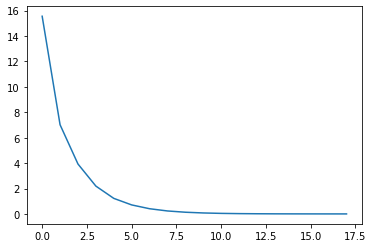

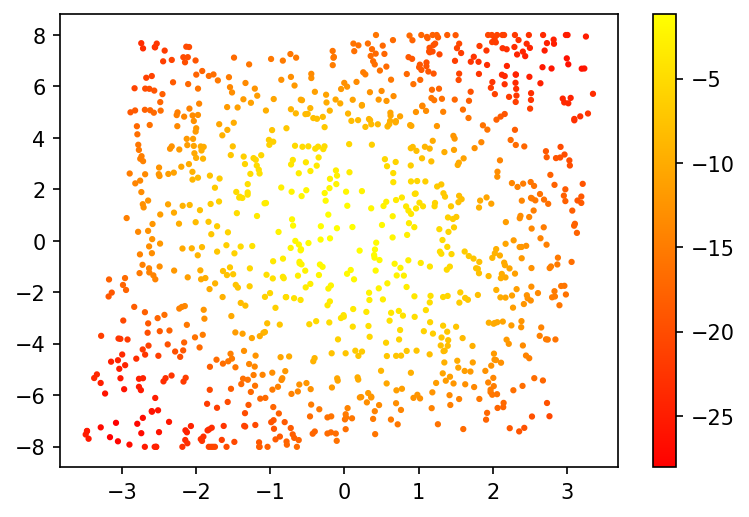

In [8]:
V = np.zeros((iterateDy[j].shape[0],1))

theta = 0.001
max_val_iter = 10000
err = np.infty

gamma = 0.99

val_iter = 0

deltas = []

CME_policy = np.zeros(nx)

while val_iter<max_val_iter and err>theta:
    if not val_iter%100:
        print('Agent '+str(j)+' iteration '+str(val_iter))
        print(err)
    V_temp = np.zeros_like(V)
    buffer = rewards + gamma*np.squeeze(alphas_new@V)
    V_temp = np.min(buffer,axis=1)
    CME_policy = np.argmin(buffer,axis=1)
    
    err = np.max(np.abs(V-V_temp))
    # deltas[val_iter] = err
    deltas.append(err)
    V = copy.deepcopy(V_temp)
    val_iter = val_iter+1
print('Agent '+str(j)+' iterations: '+str(val_iter))
plt.plot(deltas)

plt.figure(dpi=150)
plt.scatter(val_states.T[0],val_states.T[1],c=V,cmap=plt.cm.autumn,s=4)
plt.colorbar()

In [9]:
grid_dim = 50
speeds = np.linspace(-max_speed,max_speed,num=grid_dim)
angles = np.linspace(-np.pi,np.pi,num=grid_dim)

xx, yy = np.meshgrid(angles,speeds)
xy = np.vstack([xx.reshape(-1),yy.reshape(-1),]).T

xy_norm = np.vstack([xx.reshape(-1)/np.pi,yy.reshape(-1)/max_speed]).T

In [43]:
sa_grid = []
for k, state in tqdm(enumerate(xy)):
    sa_grid.extend(np.hstack((np.tile(state,[n_action,1]),actions[:,np.newaxis])))
dists = cdist(iterateDx[j],sa_grid,metric='sqeuclidean')
alphas_grid = (W_new@np.exp(-dists/(2*sigmalist[0]**2))).T + 0.0000000001
alphas_grid = np.reshape(alphas_grid,(grid_dim**2,n_action,nx))

rewards_grid = np.zeros((grid_dim**2,n_action))
for i,action in enumerate(actions):
    th = state[0]
    thdot = state[1]
    rewards_grid[k][i] = -(angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (action**2)) 

0it [00:00, ?it/s]

In [46]:
V_grid = np.zeros((grid_dim**2,1))
CME_grid_policy = np.zeros(grid_dim**2,dtype=int)
# for state in range(grid_dim**2):
#     buffer = np.zeros(n_action)
buffer = rewards_grid + gamma*alphas_grid@V
    # for action in range(n_action):
    #     # buffer[action] = rewards[state][action] + gamma*(alphas_new[state][action]@V_prod)
    #     buffer[action] = rewards_grid[state][action] + gamma*(alphas_grid[state][action]@V)
# V_grid[state] = np.min(buffer,axis=1)
# CME_grid_policy[state] = np.argmin(buffer,axis=1)
V_grid = np.min(buffer,axis=1)
CME_grid_policy = np.argmin(buffer,axis=1)

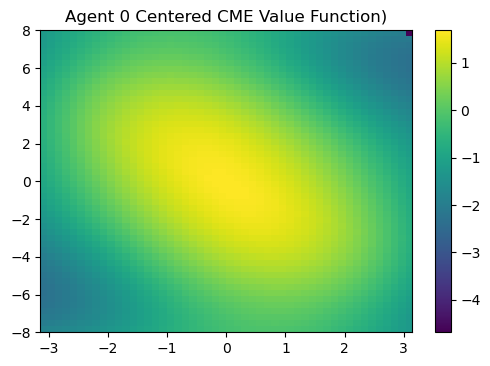

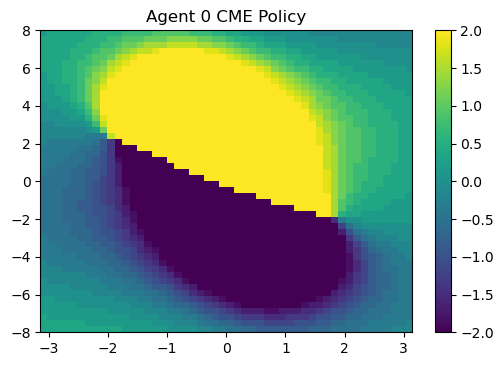

In [47]:
# for iter in range(iterations):
for j in range(num_agents):

    V_CME2d = np.reshape((V_grid-np.mean(V_grid))/np.std(V_grid),(grid_dim,grid_dim,-1))
    plt.figure(dpi=100)
    plt.imshow(V_CME2d,origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')
    plt.colorbar()
    plt.title('Agent '+str(j)+' Centered CME Value Function)')
    CME_pol2d = np.reshape(actions[CME_grid_policy],(grid_dim,grid_dim,-1))
    plt.figure(dpi=100)
    plt.imshow(CME_pol2d,origin='lower',extent=[-np.pi,np.pi,-max_speed,max_speed],aspect='auto')
    plt.title('Agent '+str(j)+' CME Policy')
    plt.colorbar()
    # cbar = plt.colorbar(ticks=[0,1,2,3]);
    # cbar.ax.set_yticklabels(['North', 'East', 'South', 'West']);

In [29]:
# in_states = iterateDx[0].T[0:2].T

rewards_grid = np.zeros((grid_dim**2,n_action))
alphas_grid = np.zeros((grid_dim**2,n_action,nx))
for k, state in tqdm(enumerate(xy)):
    dists = cdist(iterateDx[j],np.hstack((np.tile(state,[n_action,1]),actions[:,np.newaxis])),metric='sqeuclidean')
    alphas_grid[k] = (W_new@np.exp(-dists/(2*sigmalist[0]**2))).T + 0.0000000001
    alphas_grid[k] = alphas_grid[k]/np.abs(alphas_grid[k]).sum(axis=1,keepdims=True)
#     for i,action in enumerate(actions):
#         th = state[0]
#         thdot = state[1]
#         rewards_grid[k][i] = -(angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (action**2))   
#         # dists = cdist(data_in,np.tile([state,action],[1,1]),metric='sqeuclidean')
#         # dists = cdist(Dx,np.tile(np.append(xy[state],action),[1,1]),metric='sqeuclidean')
#         dists = cdist(iterateDx[j],np.tile(np.append(state,action),[1,1]),metric='sqeuclidean')
#         #alphas[state][action] = np.squeeze(W@np.exp(-dists/sigma_kernel**2))
#         alphas_grid[k][i] = np.squeeze(W_new@np.exp(-dists/(2*sigmalist[0]**2)))
#         alphas_grid[k][i] = alphas_grid[k][i]/np.sum(np.abs(alphas_grid[k][i]) + 0.0000000001)
# # alphas_agents[j] = alphas_new

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [48]:
import h5py

with h5py.File('pendulum_model_CME.h5', 'w') as hf:
    hf.create_dataset("CME_grid_V",  data=V_grid)
    hf.create_dataset("xy",  data=xy)
    hf.create_dataset("CME_grid_policy",data=CME_grid_policy)
    hf.create_dataset("xy_norm",data=xy_norm)
    hf.create_dataset("actions",data=actions)
    # hf.create_dataset("xy_next",data=xy_next)
    # hf.create_dataset("VI_policy",  data=VI_policy)
    # hf.create_dataset("VI_val_fcn", data = V_VI)
    hf.create_dataset("g",data = g)